In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


**Importing libraries**

In [ ]:
#importing required libraries 
import os 
import cv2
import math
import random
#import pafy
#import youtube_dl
import numpy as np
import datetime as dt
import tensorflow as tf
from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline
 
from sklearn.model_selection import train_test_split
 
from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, TimeDistributed
from keras.layers.convolutional import Conv3D, MaxPooling3D
#from keras.layers.recurrent import LSTM
from keras.layers import LSTM
from keras.optimizers import Adam
from keras.losses import binary_crossentropy
from keras.metrics import binary_accuracy
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import Model
from keras.layers import Input, Dense, Dropout, Conv3D, MaxPooling3D, Flatten, LSTM, concatenate
from tensorflow.keras.layers import Reshape

In [ ]:
seed_constant = 27
np.random.seed(seed_constant)
random.seed(seed_constant)
tf.random.set_seed(seed_constant)

**Loading Dataset**

In [ ]:
# Loading the dataset
dataset = '/content/drive/MyDrive/CricShot10 dataset (1)'

**Preprocessing Data**

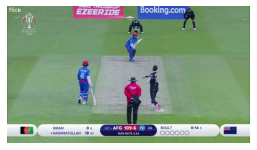

In [ ]:
# Creating a Matplotlib figure and specifying the size of the figure.
plt.figure(figsize = (20, 20))
 
# Get the names of all shots/categories in dataset.
all_classes_names = ['cover', 'defense' , 'flick']

 
# Iterating through all the shots.
for classes in all_classes_names:
 
    # Retrieving a Class Name.
    #selected_class_Name = classes
 
    # Retrieving the list of all the video files present in shot Directories.
    video_files_names_list = os.listdir(f'{dataset}/{classes}')
 
    # Randomly selecting a video file from the list retrieved video files names list.
    selected_video_file_name = random.choice(video_files_names_list)
 
    # Initializing a VideoCapture object to read from the video File.
    video_reader = cv2.VideoCapture(f'{dataset}/{classes}/{selected_video_file_name}')
    
    # Reading the first frame of the video file.
    _, bgr_frame = video_reader.read()
 
    # Releasing the VideoCapture object. 
    video_reader.release()
 
    # Converting the frame from BGR into RGB format. 
    rgb_frame = cv2.cvtColor(bgr_frame, cv2.COLOR_BGR2RGB)
 
    # Writing the class name on the video frame.
    cv2.putText(rgb_frame, classes, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)
    
    # Display the frame.
    plt.subplot(5, 4, 4);plt.imshow(rgb_frame);plt.axis('off')

In [ ]:
# Specifying the height and width to which each video frame will be resized in our dataset.
IMAGE_HEIGHT , IMAGE_WIDTH = 180, 180

# Specifying the number of frames of a video that will be fed to the model as one sequence.
SEQUENCE_LENGTH = 10

# Specifying the directory containing the dataset. 
DATASET_DIR = dataset

# Specifying the list containing the names of the classes used for training.
CLASSES_LIST = ['cover', 'defense' , 'flick']


**Extracting frames from videos**

In [ ]:
def frames_extraction(video_path):
    '''
    This function will extract the required frames from a video after resizing and normalizing them.
    Args:
        video_path: The path of the video in the disk, whose frames are to be extracted.
    Returns:
        frames_list: A list containing the resized and normalized frames of the video.
    '''

    # Declaring a list to store video frames.
    frames_list = []
    
    # Reading the Video File using the VideoCapture object.
    video_reader = cv2.VideoCapture(video_path)

    # Geting the total number of frames in the video.
    video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))

    # Calculating the the interval after which frames will be added to the list.
    skip_frames_window = max(int(video_frames_count/SEQUENCE_LENGTH), 1)

    # Iterating through the Video Frames.
    for frame_counter in range(SEQUENCE_LENGTH):

        # Setting the current frame position of the video.
        video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_counter * skip_frames_window)

        # Reading the frame from the video. 
        success, frame = video_reader.read() 

        # Checking if Video frame is not successfully read then break the loop
        if not success:
            break

        # Resizing the Frame to fixed height and width.
        resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))
        
        # Normalizing the resized frame by dividing it with 255 so that each pixel value then lies between 0 and 1
        normalized_frame = resized_frame / 255
        
        # Appending the normalized frame into the frames list
        frames_list.append(normalized_frame)
    
    # Release the VideoCapture object. 
    video_reader.release()

    # Returning the frames list.
    return frames_list


**Dataset Creation**

In [ ]:
def create_dataset():
    '''
    This function will extract the data of the selected classes and create the required dataset.
    Returns:
        features:          A list containing the extracted frames of the videos.
        labels:            A list containing the indexes of the classes associated with the videos.
        video_files_paths: A list containing the paths of the videos in the disk.
    '''

    # Declared Empty Lists to store the features, labels and video file path values.
    features = []
    labels = []
    video_files_paths = []
    
    # Iterating through all the classes mentioned in the classes list
    for class_index, class_name in enumerate(CLASSES_LIST):
        
        # Displaying the name of the class whose data is being extracted.
        print(f'Extracting Data of Class: {class_name}')
        
        # Getting the list of video files present in the specific class name directory.
        files_list = os.listdir(os.path.join(DATASET_DIR, class_name))
        
        # Iterating through all the files present in the files list.
        for file_name in files_list:
            
            # Getting the complete video path.
            video_file_path = os.path.join(DATASET_DIR, class_name, file_name)

            # Extracting the frames of the video file.
            frames = frames_extraction(video_file_path)

            # Checking if the extracted frames are equal to the SEQUENCE_LENGTH specified above.
            # So ignore the videos having frames less than the SEQUENCE_LENGTH.
            if len(frames) == SEQUENCE_LENGTH:

                # Append the data to their repective lists.
                features.append(frames)
                labels.append(class_index)
                video_files_paths.append(video_file_path)

    # Converting the list to numpy arrays
    features = np.asarray(features)
    labels = np.array(labels)  
    
    # Return the frames, class index, and video file path.
    return features, labels, video_files_paths

**Loading Features and Labels**

In [ ]:
# Create the dataset.
features, labels, video_files_paths = create_dataset()

In [ ]:
# Using Keras's to_categorical method to convert labels into one-hot-encoded vectors
one_hot_encoded_labels = to_categorical(labels)

In [ ]:
# Split the Data into Train ( 90% ) and Test Set ( 10% ).
features_train, features_test, labels_train, labels_test = train_test_split(features, one_hot_encoded_labels, test_size = 0.1, shuffle = True, random_state = seed_constant)

**Making custom LSTM model**

In [ ]:
def create_convlstm_model():
    '''
    This function will construct the required convlstm model.
    Returns:
        model: It is the required constructed convlstm model.
    '''

    # We will use a Sequential model for model construction
    model = Sequential()

    # Defining the Model Architecture.
    ########################################################################################################################
    
    model.add(ConvLSTM2D(filters = 4, kernel_size = (3, 3), activation = 'tanh',data_format = "channels_last",
                         recurrent_dropout=0.2, return_sequences=True, input_shape = (SEQUENCE_LENGTH,
                                                                                      IMAGE_HEIGHT, IMAGE_WIDTH, 3)))
    
    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
    model.add(TimeDistributed(Dropout(0.2)))
    
    model.add(ConvLSTM2D(filters = 8, kernel_size = (3, 3), activation = 'tanh', data_format = "channels_last",
                         recurrent_dropout=0.2, return_sequences=True))
    
    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
    model.add(TimeDistributed(Dropout(0.2)))
    
    model.add(ConvLSTM2D(filters = 14, kernel_size = (3, 3), activation = 'tanh', data_format = "channels_last",
                         recurrent_dropout=0.2, return_sequences=True))
    
    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
    model.add(TimeDistributed(Dropout(0.2)))
    
    model.add(ConvLSTM2D(filters = 16, kernel_size = (3, 3), activation = 'tanh', data_format = "channels_last",
                         recurrent_dropout=0.2, return_sequences=True))
    
    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
    #model.add(TimeDistributed(Dropout(0.2)))
    
    model.add(Flatten()) 
    
    model.add(Dense(len(CLASSES_LIST), activation = "softmax"))
    
    ########################################################################################################################
     
    # Displaying the models summary.
    model.summary()
    
    # Return the constructed convlstm model.
    return model

**Model Structure/Shape**

In [ ]:
# Construct the required convlstm model.
convlstm_model = create_convlstm_model()

# Display the success message. 
print("Model Created Successfully!")

In [ ]:
# Ploting the structure of the contructed model.
plot_model(convlstm_model, to_file = 'convlstm_model_structure_plot.png', show_shapes = True, show_layer_names = True)

**Training the LSTM model**

In [ ]:
# Creating an Instance of Early Stopping Callback
early_stopping_callback = EarlyStopping(monitor = 'val_loss', patience = 10, mode = 'min', restore_best_weights = True)
 
# Compiling the model and specify loss function, optimizer and metrics values to the model
convlstm_model.compile(loss = 'categorical_crossentropy', optimizer = 'Adam', metrics = ["accuracy"])

# Start training the model.
convlstm_model_training_history = convlstm_model.fit(x = features_train, y = labels_train, epochs = 50, batch_size = 16,shuffle = True, validation_split = 0.2, callbacks = [early_stopping_callback])

**Model Evaluation**

In [ ]:
# Evaluating the trained model.
accuracy, model_evaluation_history = convlstm_model.evaluate(features_test, labels_test)

# Print the test set accuracy
print('Test set accuracy:', accuracy)

In [ ]:
# Getting the loss and accuracy from model_evaluation_history.
model_evaluation_loss, model_evaluation_accuracy = model_evaluation_history

# Define the string date format.
# Get the current Date and Time in a DateTime Object.
# Convert the DateTime object to string according to the style mentioned in date_time_format string.
date_time_format = '%Y_%m_%d__%H_%M_%S'
current_date_time_dt = dt.datetime.now()
current_date_time_string = dt.datetime.strftime(current_date_time_dt, date_time_format)
 
# Defining a useful name for our model to make it easy for us while navigating through multiple saved models.
model_file_name = f'convlstm_model___Date_Time_{current_date_time_string}___Loss_{model_evaluation_loss}___Accuracy_{model_evaluation_accuracy}.h5'
 
# Saving our Model.
convlstm_model.save(model_file_name)


**Plotting Metrics**

In [ ]:
def plot_metric(model_training_history, metric_name_1, metric_name_2, plot_name):
    '''
    This function will plot the metrics passed to it in a graph.
    Args:
        model_training_history: A history object containing a record of training and validation 
                                loss values and metrics values at successive epochs
        metric_name_1:          The name of the first metric that needs to be plotted in the graph.
        metric_name_2:          The name of the second metric that needs to be plotted in the graph.
        plot_name:              The title of the graph.
    '''
    
    # Getting metric values using metric names as identifiers.
    metric_value_1 = model_training_history.history[metric_name_1]
    metric_value_2 = model_training_history.history[metric_name_2]
    
    # Constructing a range object which will be used as x-axis (horizontal plane) of the graph.
    epochs = range(len(metric_value_1))
 
    # Plotting the Graph.
    plt.plot(epochs, metric_value_1, 'blue', label = metric_name_1)
    plt.plot(epochs, metric_value_2, 'red', label = metric_name_2)
 
    # Adding title to the plot.
    plt.title(str(plot_name))
 
    # Adding legend to the plot.
    plt.legend()

In [ ]:
# Visualizing the training and validation loss metrices.
plot_metric(convlstm_model_training_history, 'loss', 'val_loss', 'Total Loss vs Total Validation Loss')

In [ ]:
# Visualizing the training and validation accuracy metrices.
plot_metric(convlstm_model_training_history, 'accuracy', 'val_accuracy', 'Total Accuracy vs Total Validation Accuracy') 

**Making custom LRCN model**

In [ ]:
def create_LRCN_model():
    '''
    This function will construct the required LRCN model.
    Returns:
        model: It is the required constructed LRCN model.
    '''
 
    # We will use a Sequential model for model construction.
    model = Sequential()
    
    # Defining the Model Architecture.
    ########################################################################################################################
    
    model.add(TimeDistributed(Conv2D(16, (3, 3), padding='same',activation = 'relu'),
                              input_shape = (SEQUENCE_LENGTH, IMAGE_HEIGHT, IMAGE_WIDTH, 3)))
    
    model.add(TimeDistributed(MaxPooling2D((4, 4)))) 
    model.add(TimeDistributed(Dropout(0.25)))
    
    model.add(TimeDistributed(Conv2D(32, (3, 3), padding='same',activation = 'relu')))
    model.add(TimeDistributed(MaxPooling2D((4, 4))))
    model.add(TimeDistributed(Dropout(0.25)))
    
    model.add(TimeDistributed(Conv2D(64, (3, 3), padding='same',activation = 'relu')))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    model.add(TimeDistributed(Dropout(0.25)))
    
    model.add(TimeDistributed(Conv2D(64, (3, 3), padding='same',activation = 'relu')))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    #model.add(TimeDistributed(Dropout(0.25)))
                                      
    model.add(TimeDistributed(Flatten()))
                                      
    model.add(LSTM(32))
                                      
    model.add(Dense(len(CLASSES_LIST), activation = 'softmax'))
 
    ########################################################################################################################
 
    # Displaying the models summary.
    model.summary()
    
    # Return the constructed LRCN model.
    return model

In [ ]:
# Construct the required LRCN model.
LRCN_model = create_LRCN_model()
 
# Display the success message.
print("Model Created Successfully!")

In [ ]:
# Plotting the structure of the contructed LRCN model.
plot_model(LRCN_model, to_file = 'LRCN_model_structure_plot.png', show_shapes = True, show_layer_names = True)

In [ ]:
# Creating an Instance of Early Stopping Callback.
early_stopping_callback = EarlyStopping(monitor = 'val_loss', patience = 15, mode = 'min', restore_best_weights = True)
 
# Compiling the model and specify loss function, optimizer and metrics to the model.
LRCN_model.compile(loss = 'categorical_crossentropy', optimizer = 'Adam', metrics = ["accuracy"])
 
# Start training the model.
LRCN_model_training_history = LRCN_model.fit(x = features_train, y = labels_train, epochs = 70, batch_size = 16 , shuffle = True, validation_split = 0.2, callbacks = [early_stopping_callback])

In [ ]:
# Evaluating the trained model.
accuracy, model_evaluation_history = LRCN_model.evaluate(features_test, labels_test)

# Print the test set accuracy
print('Test set accuracy:', accuracy)

In [ ]:
# Getting the loss and accuracy from model_evaluation_history.
model_evaluation_loss, model_evaluation_accuracy = model_evaluation_history
 
# Define the string date format.
# Get the current Date and Time in a DateTime Object.
# Convert the DateTime object to string according to the style mentioned in date_time_format string.
date_time_format = '%Y_%m_%d__%H_%M_%S'
current_date_time_dt = dt.datetime.now()
current_date_time_string = dt.datetime.strftime(current_date_time_dt, date_time_format)
    
# Defining a useful name for our model to make it easy for us while navigating through multiple saved models.
model_file_name = f'LRCN_model___Date_Time_{current_date_time_string}___Loss_{model_evaluation_loss}___Accuracy_{model_evaluation_accuracy}.h5'
 
# Save the Model.
LRCN_model.save(model_file_name)

In [ ]:
# Visualizing the training and validation loss metrices.
plot_metric(LRCN_model_training_history, 'loss', 'val_loss', 'Total Loss vs Total Validation Loss')

In [ ]:
# Visualizing the training and validation accuracy metrices.
plot_metric(LRCN_model_training_history, 'accuracy', 'val_accuracy', 'Total Accuracy vs Total Validation Accuracy')

In [ ]:
def create_vgg16_model():
    '''
    This function will construct the required vgg16 model.
    Returns:
        model: It is the required constructed vgg16 model.
    '''

    # We will use a Sequential model for model construction
    model = Sequential()

    # Defining the Model Architecture.
    ########################################################################################################################

    model.add(Conv2D(input_shape=(20,180,180,3), filters=4, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(Conv2D(filters=4,kernel_size=(3,3),padding="same", activation="relu"))
    model.add(MaxPooling3D(pool_size=(1,2,2), padding='same', data_format='channels_last'))
    
    model.add(Conv2D(filters=16, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(Conv2D(filters=16, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(MaxPooling3D(pool_size=(1,2,2), padding='same', data_format='channels_last'))
    
    model.add(Conv2D(filters=32, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(Conv2D(filters=32, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(Conv2D(filters=32, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(MaxPooling3D(pool_size=(1,2,2), padding='same', data_format='channels_last'))
    
    model.add(Conv2D(filters=64, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(Conv2D(filters=64, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(Conv2D(filters=64, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(MaxPooling3D(pool_size=(1,2,2), padding='same', data_format='channels_last'))
  
    model.add(Conv2D(filters=64, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(Conv2D(filters=64, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(Conv2D(filters=64, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(MaxPooling3D(pool_size=(1,2,2), padding='same', data_format='channels_last'))

    model.add(Flatten())
    model.add(Dense(units=2, activation="softmax"))

    ########################################################################################################################
     
    # Displaying the models summary.
    model.summary()

    # Return the constructed convlstm model.
    return model

In [ ]:
# Construct the required vgg16 model.
vgg16_model = create_vgg16_model()
 
# Display the success message.
print("Model Created Successfully!")

In [ ]:
# Plotting the structure of the contructed LRCN model.
plot_model(vgg16_model, to_file = 'vgg16_model_structure_plot.png', show_shapes = True, show_layer_names = True)

In [ ]:
# Creating an Instance of Early Stopping Callback.
early_stopping_callback = EarlyStopping(monitor = 'val_loss', patience = 15, mode = 'min', restore_best_weights = True)
 
# Compiling the model and specify loss function, optimizer and metrics to the model.
vgg16_model.compile(loss = 'categorical_crossentropy', optimizer = 'Adam', metrics = ["accuracy"])
 
# Start training the model.
vgg16_model_training_history = vgg16_model.fit(x = features_train, y = labels_train, epochs = 50, batch_size = 8 , shuffle = True, validation_split = 0.2, callbacks = [early_stopping_callback])

In [ ]:
def predict_single_action_LRCN(video_file_path, SEQUENCE_LENGTH):
    '''
    This function will perform single action recognition prediction on a video using the LRCN model.
    Args:
    video_file_path:  The path of the video stored in the disk on which the action recognition is to be performed.
    SEQUENCE_LENGTH:  The fixed number of frames of a video that can be passed to the model as one sequence.
    '''
 
    # Initialize the VideoCapture object to read from the video file.
    video_reader = cv2.VideoCapture(video_file_path)
 
    # Get the width and height of the video.
    original_video_width = int(video_reader.get(cv2.CAP_PROP_FRAME_WIDTH))
    original_video_height = int(video_reader.get(cv2.CAP_PROP_FRAME_HEIGHT))
 
    # Declare a list to store video frames we will extract.
    frames_list = []
    
    # Initialize a variable to store the predicted action being performed in the video.
    predicted_class_name = ''
 
    # Get the number of frames in the video.
    video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))
 
    # Calculate the interval after which frames will be added to the list.
    skip_frames_window = max(int(video_frames_count/SEQUENCE_LENGTH),1)
 
    # Iterating the number of times equal to the fixed length of sequence.
    for frame_counter in range(SEQUENCE_LENGTH):
 
        # Set the current frame position of the video.
        video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_counter * skip_frames_window)
 
        # Read a frame.
        success, frame = video_reader.read() 
 
        # Check if frame is not read properly then break the loop.
        if not success:
            break
 
        # Resize the Frame to fixed Dimensions.
        resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))
        
        # Normalize the resized frame by dividing it with 255 so that each pixel value then lies between 0 and 1.
        normalized_frame = resized_frame / 255
        
        # Appending the pre-processed frame into the frames list
        frames_list.append(normalized_frame)
 
    # Passing the  pre-processed frames to the model and get the predicted probabilities.
    predicted_labels_probabilities = CNN3D_model.predict(np.expand_dims(frames_list, axis = 0))[0]
 
    # Get the index of class with highest probability.
    predicted_label = np.argmax(predicted_labels_probabilities)
 
    # Get the class name using the retrieved index.
    predicted_class_name = CLASSES_LIST[predicted_label]
    
    # Display the predicted action along with the prediction confidence.
    print(f'Action Predicted: {predicted_class_name}\nConfidence: {predicted_labels_probabilities[predicted_label]}')
        
    # Release the VideoCapture object. 
    video_reader.release()

In [ ]:
# Input video file paths
input_video_path = '/content/drive/MyDrive/cover video.avi'
input_video_path_2 = '/content/drive/MyDrive/defense video.avi'
input_video_path_3 = '/content/drive/MyDrive/flick video.avi'

In [ ]:
# Perform Single Prediction on the Test Videos.
predict_single_action_LRCN(input_video_path, SEQUENCE_LENGTH)
predict_single_action_LRCN(input_video_path_2, SEQUENCE_LENGTH)
predict_single_action_LRCN(input_video_path_3, SEQUENCE_LENGTH)

In [ ]:
# Define the CNN model
def cnn_model():
    model = Sequential()
    model.add(Conv3D(32, (3, 3, 3), activation='relu', input_shape=(SEQUENCE_LENGTH, IMAGE_HEIGHT, IMAGE_WIDTH, 3)))
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))
    model.add(Conv3D(64, (3, 3, 3), activation='relu'))
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))
    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    return model

# Define the RNN model
def rnn_model():
    model = Sequential()
    model.add(LSTM(256, return_sequences=True, input_shape=(SEQUENCE_LENGTH, IMAGE_HEIGHT, IMAGE_WIDTH, 3)))
    model.add(Dropout(0.5))
    model.add(TimeDistributed(Dense(1, activation='sigmoid')))
    return model

# Combine the CNN and RNN models
def hybrid_model():
    cnn = cnn_model()
    rnn = rnn_model()
    model = Sequential()
    model.add(TimeDistributed(cnn, input_shape=(SEQUENCE_LENGTH, IMAGE_HEIGHT, IMAGE_WIDTH, 3)))
    model.add(rnn)
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))
    return model


In [ ]:
# Compile the model
cnn_input_shape = (SEQUENCE_LENGTH, IMAGE_HEIGHT, IMAGE_WIDTH, 3) # (timesteps, height, width, channels)
rnn_input_shape = (None, 180)
model = hybrid_model()
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
history = model.fit(features_train, labels_train, batch_size=32, epochs=50, shuffle = True, validation_split=0.2)

In [ ]:
def hybrid_model():
  model = Sequential()

  model.add(Conv2D(32, 4, activation='relu', padding='same'))
  model.add(LSTM(32, return_sequences=True))
  model.add(MaxPooling3D(1, 2, 2))
  model.add(Conv2D(16, 8, activation="relu", padding='same'))
  model.add(LSTM(64, return_sequences=True))
  model.add(MaxPooling3D(1, 2, 2))
  model.add(Conv2D(16, 8, activation="relu", padding='same'))
  model.add(LSTM(128))
  model.add(Dense(len(CLASSES_LIST), activation='sigmoid'))

In [ ]:
model = hybrid_model()
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

In [ ]:
history = model.fit(features_train, labels_train, batch_size=10, epochs=50)

In [ ]:
def create_3D_CNN():
  # Define the input shape
  input_shape = (SEQUENCE_LENGTH, IMAGE_HEIGHT, IMAGE_WIDTH, 3)

  # Define the input layer
  inputs = Input(shape=input_shape)

  # Add convolutional layers
  x = Conv3D(filters=32, kernel_size=(3, 3, 3), activation='relu')(inputs)
  x = MaxPooling3D(pool_size=(2, 2, 2))(x)
  x = (TimeDistributed(Dropout(0.2)))(x)
  x = Conv3D(filters=64, kernel_size=(3, 3, 3), activation='relu')(x)
  x = MaxPooling3D(pool_size=(2, 2, 2))(x)

  # Flatten the output of the convolutional layers
  x = Flatten()(x)

  # Add LSTM layer
  #x = LSTM(units=64)(x)

  # Add output layer
  outputs = Dense(units=len(CLASSES_LIST), activation='softmax')(x)

  # Define the model
  model = Model(inputs=inputs, outputs=outputs)

  # Printing model summary
  model.summary()

  return model

In [ ]:
# Construct the required vgg16 model.
CNN3D_model = create_3D_CNN()
 
# Display the success message.
print("Model Created Successfully!")

In [ ]:
# Plotting the structure of the contructed LRCN model.
plot_model(CNN3D_model, to_file = 'CNN3D_model_structure_plot.png', show_shapes = True, show_layer_names = True)

In [ ]:
# Creating an Instance of Early Stopping Callback.
early_stopping_callback = EarlyStopping(monitor = 'val_loss', patience = 15, mode = 'min', restore_best_weights = True)
 
# Compiling the model and specify loss function, optimizer and metrics to the model.
CNN3D_model.compile(loss = 'categorical_crossentropy', optimizer = 'Adam', metrics = ["accuracy"])
 
# Start training the model.
CNN3D_model_training_history = CNN3D_model.fit(x = features_train, y = labels_train, epochs = 50, batch_size = 32 , shuffle = True, validation_split = 0.1, callbacks = [early_stopping_callback])

In [ ]:
# Evaluating the trained model.
accuracy, model_evaluation_history = CNN3D_model.evaluate(features_test, labels_test)

# Print the test set accuracy
print('Test set accuracy:', accuracy)

In [ ]:
# Visualizing the training and validation loss metrices.
plot_metric(CNN3D_model_training_history, 'loss', 'val_loss', 'Total Loss vs Total Validation Loss')

In [ ]:
# Visualizing the training and validation accuracy metrices.
plot_metric(CNN3D_model_training_history, 'accuracy', 'val_accuracy', 'Total Accuracy vs Total Validation Accuracy')

In [ ]:
def predict_single_action_CNN3D(video_file_path, SEQUENCE_LENGTH):
    '''
    This function will perform single action recognition prediction on a video using the LRCN model.
    Args:
    video_file_path:  The path of the video stored in the disk on which the action recognition is to be performed.
    SEQUENCE_LENGTH:  The fixed number of frames of a video that can be passed to the model as one sequence.
    '''
 
    # Initialize the VideoCapture object to read from the video file.
    video_reader = cv2.VideoCapture(video_file_path)
 
    # Get the width and height of the video.
    original_video_width = int(video_reader.get(cv2.CAP_PROP_FRAME_WIDTH))
    original_video_height = int(video_reader.get(cv2.CAP_PROP_FRAME_HEIGHT))
 
    # Declare a list to store video frames we will extract.
    frames_list = []
    
    # Initialize a variable to store the predicted action being performed in the video.
    predicted_class_name = ''
 
    # Get the number of frames in the video.
    video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))
 
    # Calculate the interval after which frames will be added to the list.
    skip_frames_window = max(int(video_frames_count/SEQUENCE_LENGTH),1)
 
    # Iterating the number of times equal to the fixed length of sequence.
    for frame_counter in range(SEQUENCE_LENGTH):
 
        # Set the current frame position of the video.
        video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_counter * skip_frames_window)
 
        # Read a frame.
        success, frame = video_reader.read() 
 
        # Check if frame is not read properly then break the loop.
        if not success:
            break
 
        # Resize the Frame to fixed Dimensions.
        resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))
        
        # Normalize the resized frame by dividing it with 255 so that each pixel value then lies between 0 and 1.
        normalized_frame = resized_frame / 255
        
        # Appending the pre-processed frame into the frames list
        frames_list.append(normalized_frame)
 
    # Passing the  pre-processed frames to the model and get the predicted probabilities.
    predicted_labels_probabilities = CNN3D_model.predict(np.expand_dims(frames_list, axis = 0))[0]
 
    # Get the index of class with highest probability.
    predicted_label = np.argmax(predicted_labels_probabilities)
 
    # Get the class name using the retrieved index.
    predicted_class_name = CLASSES_LIST[predicted_label]
    
    # Display the predicted action along with the prediction confidence.
    print(f'Action Predicted: {predicted_class_name}\nConfidence: {predicted_labels_probabilities[predicted_label]}')
        
    # Release the VideoCapture object. 
    video_reader.release()

In [ ]:
input_video_path = '/content/drive/MyDrive/Val data/Video 1.avi'  #cover
input_video_path_2 = '/content/drive/MyDrive/Val data/Video 3.avi'  #defence
input_video_path_3 = '/content/drive/MyDrive/Val data/Video 6.avi'  #flick
input_video_path_4 = '/content/drive/MyDrive/Val data/Video 2.avi'  #cover
input_video_path_5 = '/content/drive/MyDrive/Val data/Video 5.avi'  #flick
input_video_path_6 = '/content/drive/MyDrive/Val data/Video 4.avi'  #defence

In [ ]:
# Perform Single Prediction on the Test Videos.
predict_single_action_CNN3D(input_video_path, SEQUENCE_LENGTH)
predict_single_action_CNN3D(input_video_path_2, SEQUENCE_LENGTH)
predict_single_action_CNN3D(input_video_path_3, SEQUENCE_LENGTH)
predict_single_action_CNN3D(input_video_path_4, SEQUENCE_LENGTH)
predict_single_action_CNN3D(input_video_path_5, SEQUENCE_LENGTH)
predict_single_action_CNN3D(input_video_path_6, SEQUENCE_LENGTH)